In [1]:
import pandas as pd
import numpy as np
import random
import os
import gc

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None  # default='warn'

from autogluon.tabular import TabularPredictor, TabularDataset

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

train = pd.read_csv('train_fillna.csv')
test = pd.read_csv('test_fillna.csv')

In [4]:
train = pd.read_csv('train_fillna.csv')
test = pd.read_csv('test_fillna.csv')
train

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,...,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR,year,month,day,hour,minute
0,SG,GIW5,Container,30.881018,2018-12-17 21:29:00,Z618338,30.0,24,24300,10.0,...,26.566667,2.472586,5,0.002615,3.450000,2018,12,17,21,29
1,IN,UJM2,Bulk,0.000000,2014-09-23 06:59:00,X886125,30.0,13,35900,10.0,...,30.420000,2.859073,12,0.000217,0.000000,2014,9,23,6,59
2,CN,EUC8,Container,0.000000,2015-02-03 22:00:00,T674582,50.0,12,146000,30.0,...,7.828889,3.436586,6,0.001614,0.000000,2015,2,3,22,0
3,JP,ZAG4,Container,0.000000,2020-01-17 04:02:00,Y847238,20.0,18,6910,10.0,...,6.700000,2.629350,13,0.000356,0.000000,2020,1,17,4,2
4,SG,GIW5,Container,27.037650,2020-01-26 07:51:00,A872328,50.0,10,116000,20.0,...,25.600000,2.495953,15,0.002615,253.554444,2020,1,26,7,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
391905,JP,QYY1,Container,0.000000,2017-06-06 05:02:00,Y375615,20.0,27,6820,10.0,...,26.471795,2.025558,14,0.000552,0.000000,2017,6,6,5,2
391906,SG,GIW5,Bulk,5.884603,2019-10-16 00:36:00,K635567,10.0,12,3160,10.0,...,27.300000,1.253491,8,0.002615,144.061389,2019,10,16,0,36
391907,US,QGN3,Bulk,70.660241,2021-03-23 22:35:00,J284147,30.0,8,60300,20.0,...,21.100000,4.766257,18,0.000155,41.482222,2021,3,23,22,35
391908,TW,JWI3,Container,9.448179,2015-01-08 07:15:00,J644215,30.0,29,23800,10.0,...,20.960784,3.173085,15,0.000990,7.485278,2015,1,8,7,15


In [5]:
train['U_WIND'].fillna(train['U_WIND'].mean(), inplace=True)
train['V_WIND'].fillna(train['V_WIND'].mean(), inplace=True)
train['AIR_TEMPERATURE'].fillna(train['AIR_TEMPERATURE'].mean(), inplace=True)
train['BN'].fillna(train['BN'].mean(), inplace=True)

In [6]:
test['U_WIND'].fillna(train['U_WIND'].mean(), inplace=True)
test['V_WIND'].fillna(train['V_WIND'].mean(), inplace=True)
test['AIR_TEMPERATURE'].fillna(train['AIR_TEMPERATURE'].mean(), inplace=True)
test['BN'].fillna(train['BN'].mean(), inplace=True)

In [7]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute

In [8]:
# datetime 컬럼 처리
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute

In [9]:
train_dist=train
test_dist=test

In [10]:
# train_dist_zero=train[train['DIST']==0]
# train_dist=train[train['DIST']!=0]
# test_dist_zero=test[test['DIST']==0]
# test_dist=test[test['DIST']!=0]

In [11]:
train_dist['GT/Port_Size']=train_dist['GT']/train_dist['PORT_SIZE'] 
test_dist['GT/Port_Size']=test_dist ['GT']/test_dist ['PORT_SIZE']
# train_dist['SIZE/Port_Size']=(train_dist['LENGTH']*train_dist['BREADTH']*train_dist['DEPTH'])/train_dist['PORT_SIZE'] 
# test_dist['SIZE/Port_Size']=(test_dist['LENGTH']*test_dist['BREADTH']*test_dist['DEPTH'])/test_dist ['PORT_SIZE']

In [12]:
# 풍향 계산
import math
wind_direction_rad_train = [math.atan2(float(u), float(v)) for u, v in zip(train_dist['U_WIND'], train_dist['V_WIND'])]
wind_direction_train = [math.degrees(rad) for rad in wind_direction_rad_train]
wind_direction_rad_test = [math.atan2(float(u), float(v)) for u, v in zip(test_dist['U_WIND'], test_dist['V_WIND'])]
wind_direction_test = [math.degrees(rad) for rad in wind_direction_rad_test]
train_dist['WIND_DIRECTION']=wind_direction_train
test_dist['WIND_DIRECTION']=wind_direction_test

In [13]:
# # 풍속 계산
# U_WIND_array_train = train_dist['U_WIND'].values
# V_WIND_array_train = train_dist['V_WIND'].values
# wind_speed_array_train = np.sqrt(U_WIND_array_train**2 + V_WIND_array_train**2)
# U_WIND_array_test = test_dist['U_WIND'].values
# V_WIND_array_test = test_dist['V_WIND'].values
# wind_speed_array_test = np.sqrt(U_WIND_array_test**2 + V_WIND_array_test**2)
# train_dist['WIND_SPEED'] = wind_speed_array_train
# test_dist['WIND_SPEED'] = wind_speed_array_test

In [14]:
train_dist['ARI_CO_mean']=0
test_dist['ARI_CO_mean']=0
# train_dist에 ARI_CO_mean 변수 추가
ARI_CO_mean=[]
for i in train_dist['ARI_CO'].unique():
    ARI_CO_mean.append(train_dist[train_dist['ARI_CO']==i]['CI_HOUR'].mean())
for j in range(len(train_dist['ARI_CO'].unique())):
    train_dist.loc[train_dist['ARI_CO'] == train_dist['ARI_CO'].unique()[j]
                   , 'ARI_CO_mean'] = ARI_CO_mean[j]
for k in range(len(train_dist['ARI_CO'].unique())):
    test_dist.loc[test_dist['ARI_CO'] == train_dist['ARI_CO'].unique()[k]
                   , 'ARI_CO_mean'] = ARI_CO_mean[k]

In [15]:
train_dist['ARI_PO_mean']=0
test_dist['ARI_PO_mean']=0
ARI_PO_mean=[]
for i in train_dist['ARI_PO'].unique():
    ARI_PO_mean.append(train_dist[train_dist['ARI_PO']==i]['CI_HOUR'].mean())
for j in range(len(train_dist['ARI_PO'].unique())):
    train_dist.loc[train_dist['ARI_PO'] == train_dist['ARI_PO'].unique()[j]
                   , 'ARI_PO_mean'] = ARI_PO_mean[j]
for k in range(len(train_dist['ARI_PO'].unique())):
    test_dist.loc[test_dist['ARI_PO'] == train_dist['ARI_PO'].unique()[k]
                   , 'ARI_PO_mean'] = ARI_PO_mean[k]    

In [16]:
from datetime import date
for i in train_dist.index:
    train_dist.loc[i, 'weekday'] = date(train_dist['year'][i],
                                 train_dist['month'][i],
                                 train_dist['day'][i]).weekday()
for i in test_dist.index:
    test_dist.loc[i, 'weekday'] = date(test_dist['year'][i],
                                 test_dist['month'][i],
                                 test_dist['day'][i]).weekday()

In [17]:
train_dist.corr()

,DIST,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,U_WIND,V_WIND,...,year,month,day,hour,minute,GT/Port_Size,WIND_DIRECTION,ARI_CO_mean,ARI_PO_mean,weekday
DIST,1.000000,0.025314,-0.004936,0.025461,-0.001073,0.031899,0.015930,0.025169,-0.038201,0.053854,...,0.019059,-0.018910,0.004700,-0.001196,-0.001039,-0.045550,-0.036607,-0.039132,0.019239,0.106307
BREADTH,0.025314,1.000000,-0.209535,0.857129,0.790471,0.761307,0.903987,0.920645,-0.054858,0.025234,...,-0.198336,0.008748,-0.003440,-0.016003,-0.047565,0.291277,-0.055839,0.229298,0.178080,0.015123
BUILT,-0.004936,-0.209535,1.000000,-0.240305,-0.205510,-0.147012,-0.238188,-0.180435,0.005493,-0.013453,...,-0.122062,0.002035,-0.000620,0.010325,-0.023994,-0.096967,-0.010246,-0.083585,-0.067729,-0.009761
DEADWEIGHT,0.025461,0.857129,-0.240305,1.000000,0.712959,0.813416,0.925140,0.826762,-0.028211,0.043284,...,-0.132201,0.017619,-0.003411,-0.019387,-0.031256,0.414831,-0.011614,0.263904,0.235833,0.041500
DEPTH,-0.001073,0.790471,-0.205510,0.712959,1.000000,0.581038,0.787591,0.842633,-0.044809,0.030043,...,-0.169558,0.012079,-0.003978,-0.005871,-0.047796,0.215453,-0.047839,0.188962,0.168444,0.010669
DRAUGHT,0.031899,0.761307,-0.147012,0.813416,0.581038,1.000000,0.779038,0.737592,-0.032586,0.030661,...,-0.161659,0.010627,-0.003794,-0.023205,-0.038055,0.336758,-0.024211,0.194011,0.143987,0.026812
GT,0.015930,0.903987,-0.238188,0.925140,0.787591,0.779038,1.000000,0.916687,-0.043806,0.024274,...,-0.142435,0.010653,-0.004035,-0.016813,-0.035663,0.313256,-0.037465,0.225684,0.182534,0.013473
LENGTH,0.025169,0.920645,-0.180435,0.826762,0.842633,0.737592,0.916687,1.000000,-0.056731,0.023413,...,-0.228535,0.010418,-0.003742,-0.012944,-0.058401,0.266019,-0.063245,0.212567,0.158369,0.003541
U_WIND,-0.038201,-0.054858,0.005493,-0.028211,-0.044809,-0.032586,-0.043806,-0.056731,1.000000,0.110549,...,0.027618,0.009041,0.008477,0.002200,0.003494,0.007710,0.621535,-0.056876,-0.060188,0.006039
V_WIND,0.053854,0.025234,-0.013453,0.043284,0.030043,0.030661,0.024274,0.023413,0.110549,1.000000,...,-0.006608,-0.026016,0.002616,0.003009,0.010268,0.061630,0.114050,0.058237,0.078923,0.014752


In [18]:
# Categorical 컬럼 인코딩
train_dist=train_dist.drop(columns='ATA')
test_dist=test_dist.drop(columns='ATA')
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train_dist[feature] = le.fit_transform(train_dist[feature].astype(str))
    le_classes_set = set(le.classes_)
    test_dist[feature] = test_dist[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test_dist[feature] = le.transform(test_dist[feature].astype(str))
    encoders[feature] = le

Encoding features: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  4.96it/s]


In [22]:
train_dist_small= train_dist[(train_dist['PORT_SIZE']<=0.0005)|(train_dist['PORT_SIZE']>0.0020)]
train_dist_middle = train_dist[(train_dist['PORT_SIZE']>0.0005)&(train_dist['PORT_SIZE']<=0.0020)]

In [23]:
X_test_small= test_dist[(train_dist['PORT_SIZE']<=0.0005)|(train_dist['PORT_SIZE']>0.0020)]
X_test_middle = test_dist[(test_dist['PORT_SIZE']>0.0005)&(test_dist['PORT_SIZE']<=0.0020)]

In [24]:
X_train_small = train_dist_small.drop(columns='CI_HOUR')
X_train_middle = train_dist_middle.drop(columns='CI_HOUR')

y_train_small = train_dist_small['CI_HOUR'].reset_index(drop=True)
y_train_middle = train_dist_middle['CI_HOUR'].reset_index(drop=True)

In [25]:
test_small_index=X_test_small.index
test_middle_index=X_test_middle.index

In [26]:
def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)
    
    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()
    
    return model, feature_importances

Model Tune for LGBM.


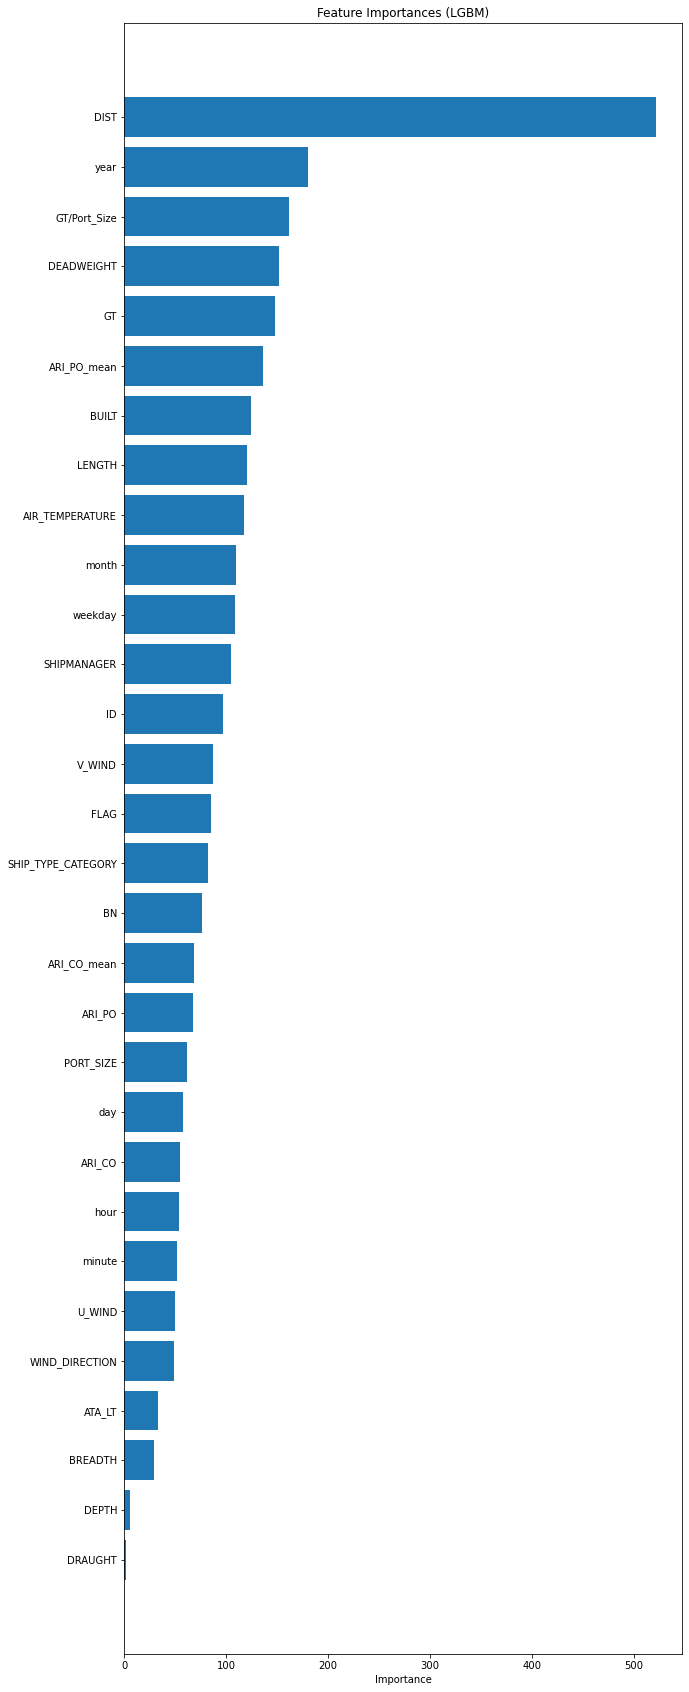

In [27]:
# Model Tune for LGBM
lgbm_model, lgbm_feature_importances1 = train_and_evaluate(lgb.LGBMRegressor()
                                                          , 'LGBM'
                                                          , X_train_small, y_train_small)

In [28]:
 X_train_small.corr()>0.7

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,...,year,month,day,hour,minute,GT/Port_Size,WIND_DIRECTION,ARI_CO_mean,ARI_PO_mean,weekday
ARI_CO,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
ARI_PO,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
SHIP_TYPE_CATEGORY,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
DIST,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
ID,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
BREADTH,False,False,False,False,False,True,False,True,True,True,...,False,False,False,False,False,False,False,False,False,False
BUILT,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
DEADWEIGHT,False,False,False,False,False,True,False,True,True,True,...,False,False,False,False,False,False,False,False,False,False
DEPTH,False,False,False,False,False,True,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
DRAUGHT,False,False,False,False,False,True,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False


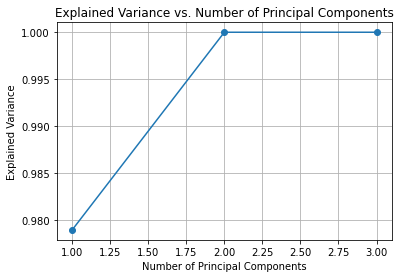

In [29]:
from sklearn.decomposition import PCA

# 주성분 개수 범위 설정
n_components_range = range(1, 4)
explained_variance = []

for n in n_components_range:
    # PCA 모델 생성
    pca = PCA(n_components=n)
    pca.fit(X_train_small[['BREADTH', 'GT', 'LENGTH', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT']])
    # 누적 설명된 분산 저장
    explained_variance.append(np.sum(pca.explained_variance_ratio_))

plt.plot(n_components_range, explained_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance vs. Number of Principal Components')
plt.grid(True)
plt.show()


In [30]:
# PCA 모델 생성 및 차원 축소
pca = PCA(n_components=1)  # 주성분 개수를 2로 설정
X_train_small['SHIP_ PHYSICAL'] = pca.fit_transform(X_train_small[['BREADTH', 'GT', 'LENGTH', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT']])
X_test_small['SHIP_ PHYSICAL'] = pca.transform(X_test_small[['BREADTH', 'GT', 'LENGTH', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT']])
                                                 

In [31]:
X_train_small=X_train_small.drop(columns=['BREADTH', 'GT', 'LENGTH', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT'])
X_test_small=X_test_small.drop(columns=['BREADTH', 'GT', 'LENGTH', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT'])

Model Tune for LGBM.


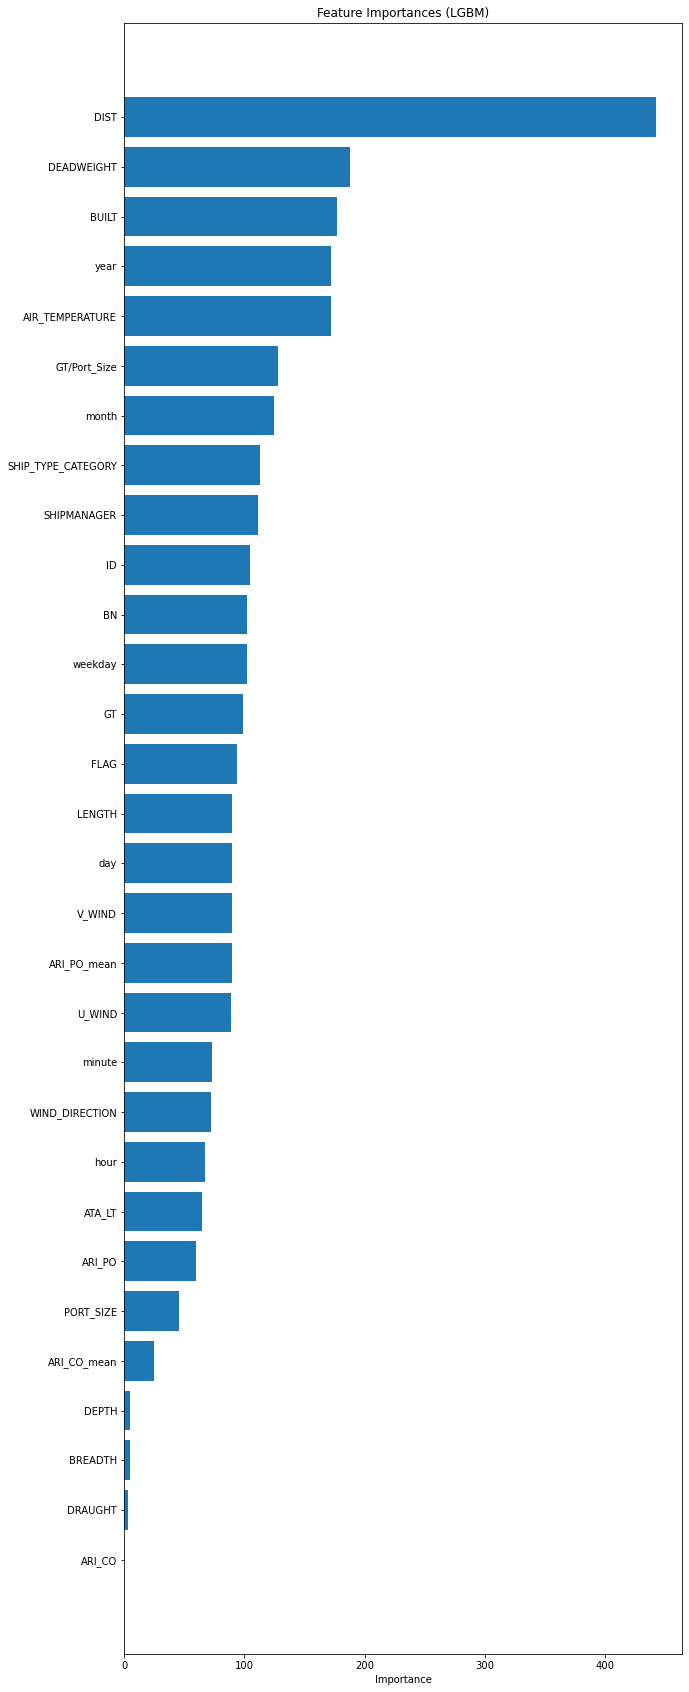

In [32]:
# Model Tune for LGBM
lgbm_model, lgbm_feature_importances2 = train_and_evaluate(lgb.LGBMRegressor()
                                                          , 'LGBM'
                                                          , X_train_middle, y_train_middle)

In [33]:
 X_train_middle.corr()>0.7

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,...,year,month,day,hour,minute,GT/Port_Size,WIND_DIRECTION,ARI_CO_mean,ARI_PO_mean,weekday
ARI_CO,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
ARI_PO,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
SHIP_TYPE_CATEGORY,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
DIST,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
ID,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
BREADTH,False,False,False,False,False,True,False,True,True,True,...,False,False,False,False,False,True,False,False,False,False
BUILT,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
DEADWEIGHT,False,False,False,False,False,True,False,True,True,True,...,False,False,False,False,False,True,False,False,False,False
DEPTH,False,False,False,False,False,True,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
DRAUGHT,False,False,False,False,False,True,False,True,False,True,...,False,False,False,False,False,False,False,False,False,False


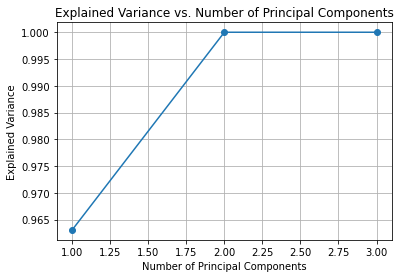

In [34]:
from sklearn.decomposition import PCA

# 주성분 개수 범위 설정
n_components_range = range(1, 4)
explained_variance = []

for n in n_components_range:
    # PCA 모델 생성
    pca = PCA(n_components=n)
    pca.fit(X_train_middle[['BREADTH', 'GT', 'LENGTH', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT']])
    # 누적 설명된 분산 저장
    explained_variance.append(np.sum(pca.explained_variance_ratio_))

plt.plot(n_components_range, explained_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance')
plt.title('Explained Variance vs. Number of Principal Components')
plt.grid(True)
plt.show()

In [35]:
# PCA 모델 생성 및 차원 축소
pca = PCA(n_components=1)  # 주성분 개수를 2로 설정
X_train_middle['SHIP_ PHYSICAL'] = pca.fit_transform(X_train_middle[['BREADTH', 'GT', 'LENGTH', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT']])
X_test_middle['SHIP_ PHYSICAL'] = pca.transform(X_test_middle[['BREADTH', 'GT', 'LENGTH', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT']])

In [36]:
X_train_middle=X_train_middle.drop(columns=['BREADTH', 'GT', 'LENGTH', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT'])
X_test_middle=X_test_middle.drop(columns=['BREADTH', 'GT', 'LENGTH', 'DEADWEIGHT', 'DEPTH', 'DRAUGHT'])

In [37]:
scaler_small = MinMaxScaler()
scaler_middle = MinMaxScaler()


X_train_small = pd.DataFrame(scaler_small.fit_transform(X_train_small)
                               , columns=X_train_small.columns)
X_train_middle = pd.DataFrame(scaler_middle.fit_transform(X_train_middle)
                               , columns=X_train_middle.columns)

X_test_small = pd.DataFrame(scaler_small.transform(X_test_small),
                              columns=X_test_small.columns)
X_test_middle = pd.DataFrame(scaler_middle.transform(X_test_middle),
                              columns=X_test_middle.columns)

In [38]:
 X_train_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230475 entries, 0 to 230474
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ARI_CO              230475 non-null  float64
 1   ARI_PO              230475 non-null  float64
 2   SHIP_TYPE_CATEGORY  230475 non-null  float64
 3   DIST                230475 non-null  float64
 4   ID                  230475 non-null  float64
 5   BUILT               230475 non-null  float64
 6   SHIPMANAGER         230475 non-null  float64
 7   FLAG                230475 non-null  float64
 8   U_WIND              230475 non-null  float64
 9   V_WIND              230475 non-null  float64
 10  AIR_TEMPERATURE     230475 non-null  float64
 11  BN                  230475 non-null  float64
 12  ATA_LT              230475 non-null  float64
 13  PORT_SIZE           230475 non-null  float64
 14  year                230475 non-null  float64
 15  month               230475 non-nul

Model Tune for LGBM.


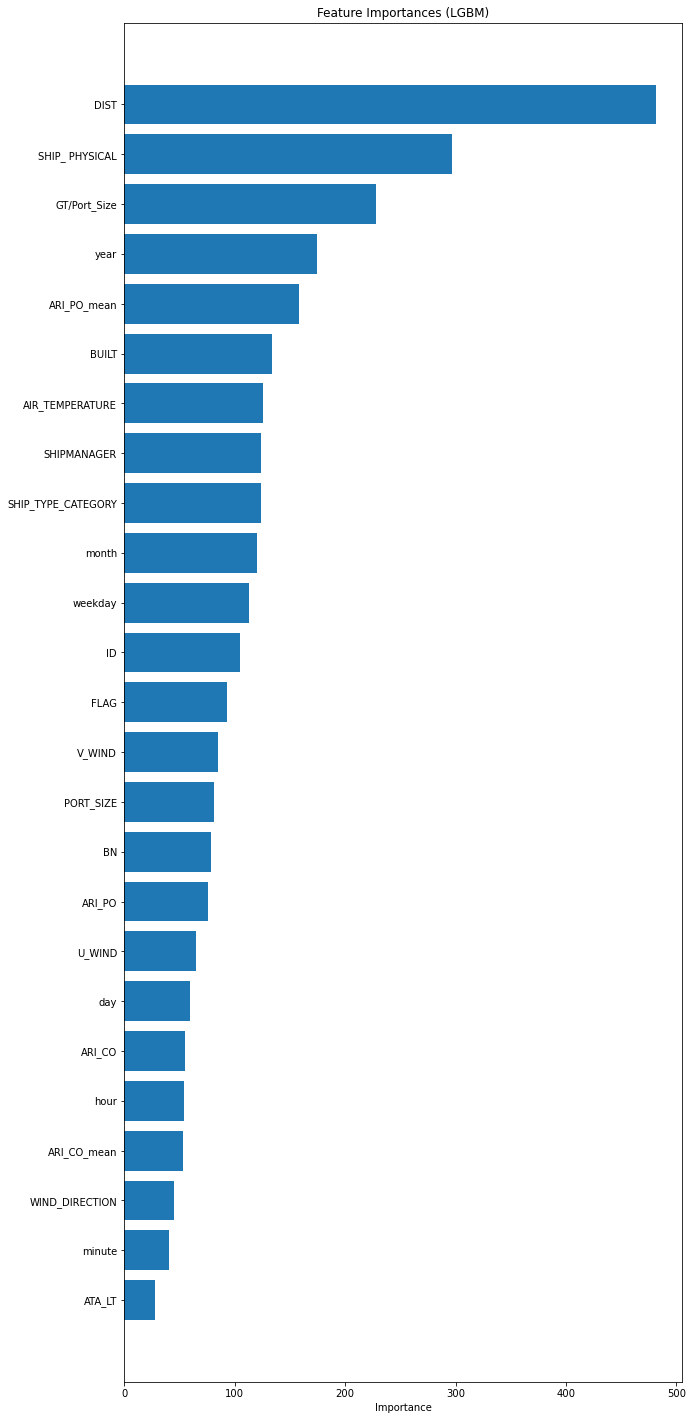

In [39]:
# Model Tune for LGBM
lgbm_model, lgbm_feature_importances1 = train_and_evaluate(lgb.LGBMRegressor()
                                                          , 'LGBM'
                                                          , X_train_small, y_train_small)

Model Tune for LGBM.


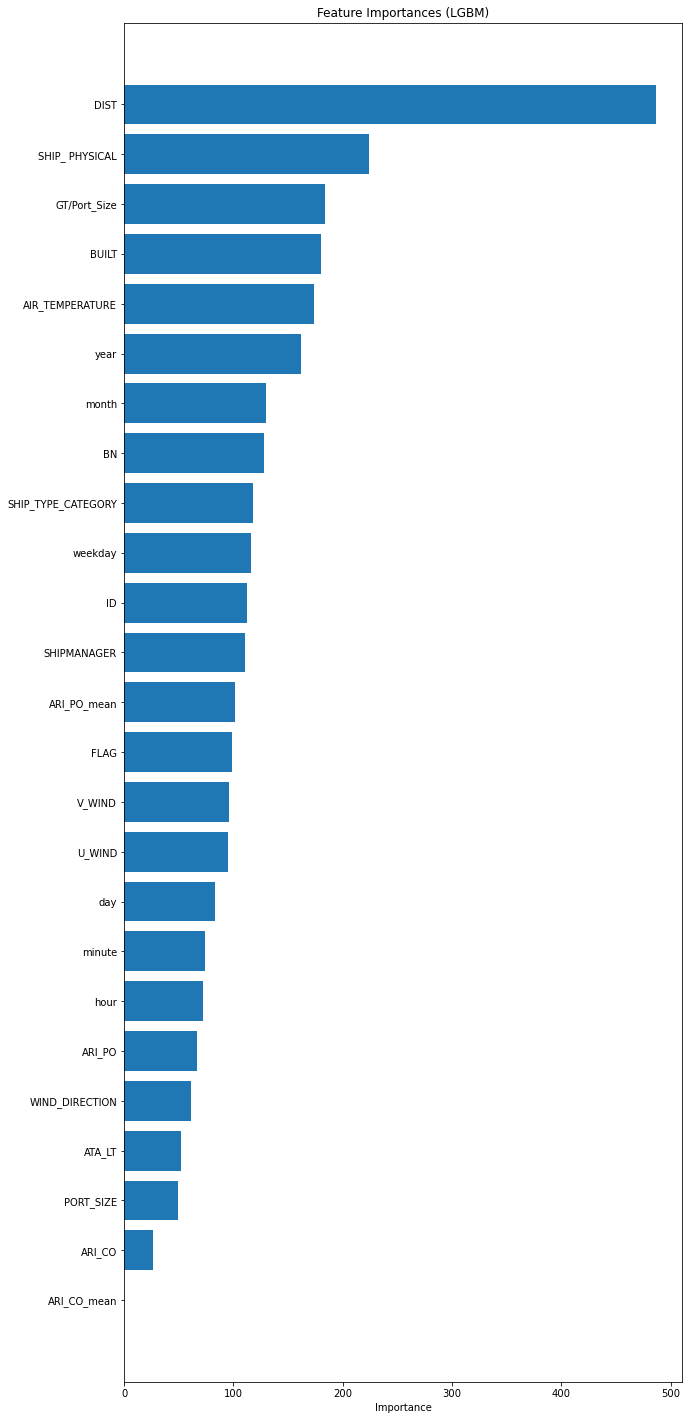

In [40]:
# Model Tune for LGBM
lgbm_model, lgbm_feature_importances2 = train_and_evaluate(lgb.LGBMRegressor()
                                                          , 'LGBM'
                                                          , X_train_middle, y_train_middle)

In [41]:
threshold = 95 # Your Threshold
low_importance_features_small= X_train_small.columns[lgbm_feature_importances1 < threshold]
low_importance_features_middle= X_train_middle.columns[lgbm_feature_importances2 < threshold]

X_train_reduced_small = X_train_small.drop(columns=low_importance_features_small)
X_test_reduced_small = X_test_small.drop(columns=low_importance_features_small)
X_train_reduced_middle = X_train_middle.drop(columns=low_importance_features_middle)
X_test_reduced_middle = X_test_middle.drop(columns=low_importance_features_middle)

In [42]:
X_train_reduced_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230475 entries, 0 to 230474
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   SHIP_TYPE_CATEGORY  230475 non-null  float64
 1   DIST                230475 non-null  float64
 2   ID                  230475 non-null  float64
 3   BUILT               230475 non-null  float64
 4   SHIPMANAGER         230475 non-null  float64
 5   AIR_TEMPERATURE     230475 non-null  float64
 6   year                230475 non-null  float64
 7   month               230475 non-null  float64
 8   GT/Port_Size        230475 non-null  float64
 9   ARI_PO_mean         230475 non-null  float64
 10  weekday             230475 non-null  float64
 11  SHIP_ PHYSICAL      230475 non-null  float64
dtypes: float64(12)
memory usage: 21.1 MB


In [43]:
X_train_reduced_small=X_train_reduced_small.drop(columns=['ID', 'SHIPMANAGER', 'BUILT'])

In [44]:
X_train_reduced_middle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161435 entries, 0 to 161434
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   SHIP_TYPE_CATEGORY  161435 non-null  float64
 1   DIST                161435 non-null  float64
 2   ID                  161435 non-null  float64
 3   BUILT               161435 non-null  float64
 4   SHIPMANAGER         161435 non-null  float64
 5   FLAG                161435 non-null  float64
 6   U_WIND              161435 non-null  float64
 7   V_WIND              161435 non-null  float64
 8   AIR_TEMPERATURE     161435 non-null  float64
 9   BN                  161435 non-null  float64
 10  year                161435 non-null  float64
 11  month               161435 non-null  float64
 12  GT/Port_Size        161435 non-null  float64
 13  ARI_PO_mean         161435 non-null  float64
 14  weekday             161435 non-null  float64
 15  SHIP_ PHYSICAL      161435 non-nul

In [45]:
X_train_reduced_middle=X_train_reduced_middle.drop(columns=['ID', 'SHIPMANAGER', 'BUILT'])

In [46]:
X_train_reduced_small['CI_HOUR']=y_train_small
X_train_reduced_middle['CI_HOUR']=y_train_middle

In [47]:
predictor_small = TabularPredictor(label='CI_HOUR',problem_type = 'regression',eval_metric='mae' )   
predictor_small.fit(train_data = X_train_reduced_small, presets = 'best_quality',
              auto_stack = True, fit_weighted_ensemble = True,
              num_bag_folds = 2, num_bag_sets = 3, num_stack_levels = 2,
              num_cpus = 8, verbosity = 2)

No path specified. Models will be saved in: "AutogluonModels\ag-20231019_070424\"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=2, num_bag_folds=2, num_bag_sets=3
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20231019_070424\"
AutoGluon Version:  0.8.2
Python Version:     3.9.12
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Disk Space Avail:   87.78 GB / 237.15 GB (37.0%)
Train Data Rows:    230475
Train Data Columns: 9
Label Column: CI_HOUR
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    7916.8 MB
	Train Data (Original)  Memory Usage: 16.59 MB (0.2% of avail

	-65.5143	 = Validation score   (-mean_absolute_error)
	7.99s	 = Training   runtime
	6.52s	 = Validation runtime
Fitting model: LightGBM_BAG_L3 ...
	Fitting 6 child models (S1F1 - S3F2) | Fitting with ParallelLocalFoldFittingStrategy
	-65.3892	 = Validation score   (-mean_absolute_error)
	7.71s	 = Training   runtime
	4.56s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L3 ...
	-69.2674	 = Validation score   (-mean_absolute_error)
	290.62s	 = Training   runtime
	8.47s	 = Validation runtime
Fitting model: CatBoost_BAG_L3 ...
	Fitting 6 child models (S1F1 - S3F2) | Fitting with ParallelLocalFoldFittingStrategy
	-65.3623	 = Validation score   (-mean_absolute_error)
	15.25s	 = Training   runtime
	0.16s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L3 ...
	-68.6104	 = Validation score   (-mean_absolute_error)
	39.48s	 = Training   runtime
	6.97s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L3 ...
	Fitting 6 child models (S1F1 - S3F2) | Fitting with ParallelLoca

In [48]:
predictor_middle = TabularPredictor(label='CI_HOUR',problem_type = 'regression',eval_metric='mae' )   
predictor_middle.fit(train_data = X_train_reduced_middle, presets = 'best_quality',
              auto_stack = True, fit_weighted_ensemble = True,
              num_bag_folds = 2, num_bag_sets = 3, num_stack_levels = 2,
              num_cpus = 8, verbosity = 2)

No path specified. Models will be saved in: "AutogluonModels\ag-20231019_080027\"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=2, num_bag_folds=2, num_bag_sets=3
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20231019_080027\"
AutoGluon Version:  0.8.2
Python Version:     3.9.12
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
Disk Space Avail:   81.29 GB / 237.15 GB (34.3%)
Train Data Rows:    161435
Train Data Columns: 13
Label Column: CI_HOUR
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    9149.05 MB
	Train Data (Original)  Memory Usage: 16.79 MB (0.2% of ava

	-30.3716	 = Validation score   (-mean_absolute_error)
	6.58s	 = Training   runtime
	2.89s	 = Validation runtime
Fitting model: LightGBM_BAG_L3 ...
	Fitting 6 child models (S1F1 - S3F2) | Fitting with ParallelLocalFoldFittingStrategy
	-30.2858	 = Validation score   (-mean_absolute_error)
	6.43s	 = Training   runtime
	2.57s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L3 ...
	-32.8635	 = Validation score   (-mean_absolute_error)
	197.15s	 = Training   runtime
	6.09s	 = Validation runtime
Fitting model: CatBoost_BAG_L3 ...
	Fitting 6 child models (S1F1 - S3F2) | Fitting with ParallelLocalFoldFittingStrategy
	-30.2263	 = Validation score   (-mean_absolute_error)
	11.78s	 = Training   runtime
	0.15s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L3 ...
	-32.6369	 = Validation score   (-mean_absolute_error)
	29.65s	 = Training   runtime
	5.44s	 = Validation runtime
Fitting model: NeuralNetFastAI_BAG_L3 ...
	Fitting 6 child models (S1F1 - S3F2) | Fitting with ParallelLoca

In [49]:
pred_y_small = predictor_small.predict(X_test_reduced_small)
pred_y_middle = predictor_middle.predict(X_test_reduced_middle)

In [50]:
pred_y_small.index=test_small_index
pred_y_middle.index=test_middle_index

In [51]:
submit = pd.read_csv('../DAT/sample_submission.csv')
submit.loc[pred_y_small.index, 'CI_HOUR'] = pred_y_small
submit.loc[pred_y_middle.index, 'CI_HOUR'] = pred_y_middle
submit

,SAMPLE_ID,CI_HOUR
0,TEST_000000,1.794653
1,TEST_000001,5.038469
2,TEST_000002,39.059639
3,TEST_000003,51.776306
4,TEST_000004,0.010708
...,...,...
220486,TEST_220486,0.000000
220487,TEST_220487,0.000000
220488,TEST_220488,45.844360
220489,TEST_220489,0.010651


In [52]:
test_dist_index=test[test['DIST']==0].index
test_dist_index

Int64Index([     4,      5,     11,     19,     22,     24,     25,     26,
                27,     28,
            ...
            220469, 220470, 220472, 220474, 220477, 220481, 220482, 220483,
            220485, 220489],
           dtype='int64', length=88430)

In [53]:
submit.loc[test_dist_index, 'CI_HOUR']=0

In [54]:
submit

,SAMPLE_ID,CI_HOUR
0,TEST_000000,1.794653
1,TEST_000001,5.038469
2,TEST_000002,39.059639
3,TEST_000003,51.776306
4,TEST_000004,0.000000
...,...,...
220486,TEST_220486,0.000000
220487,TEST_220487,0.000000
220488,TEST_220488,45.844360
220489,TEST_220489,0.000000


In [55]:
submit.to_csv('./submit2-3.csv', index=False)